In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# import logging
import os

import yaml

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import astropy.units as u
import galcheat
import madness_deblender.boxplot
import matplotlib as mpl

# import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pdf2image import convert_from_path

from madness_benchmark.utils import get_benchmark_config_path

mpl.rcParams["text.usetex"] = True
mpl.rcParams["savefig.dpi"] = 1200
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{bm} \usepackage{amsmath}"  # for \text command

In [ ]:
with open(get_benchmark_config_path()) as f:
    benchmark_config_ = yaml.safe_load(f)

In [ ]:
density_level = "high"
data_path = os.path.join(
    benchmark_config_["RESULTS_PATH"][benchmark_config_["survey_name"]],
    density_level + "_density",
)
run_name = "kl2"  # 12 to 20 galaxies
result_dir_path = os.path.join(data_path, run_name)

In [ ]:
scarlet_plot_color = sns.color_palette("colorblind")[4]
madness_plot_color = sns.color_palette("colorblind")[0]
debvader_plot_color = sns.color_palette("colorblind")[2]

isolated_plot_color = sns.color_palette("colorblind")[6]
blended_plot_color = sns.color_palette("colorblind")[1]

madness_plot_ls = "dashdot"
debvader_plot_ls = "dotted"
scarlet_plot_ls = "-"

isolated_plot_ls = "dotted"
blended_plot_ls = "--"

scarlet_plot_label = r"\textsc{scarlet}"
madness_plot_label = r"\texttt{MADNESS}"
debvader_plot_label = r"\texttt{VAE-deblender}"

In [ ]:
color_limits = (-0.3, 1.5)
snr_limits = (0, 1000)

## Load the data

In [ ]:
madness_results = []
debvader_results = []
scarlet_results = []
actual_photometry = []
blended_photometry = []

for file_num in range(300):

    madness_results.append(
        pd.read_pickle(
            os.path.join(result_dir_path, "madness_results", str(file_num) + ".pkl")
        )
    )
    debvader_results.append(
        pd.read_pickle(
            os.path.join(result_dir_path, "debvader_results", str(file_num) + ".pkl")
        )
    )
    scarlet_results.append(
        pd.read_pickle(
            os.path.join(data_path, "scarlet_results", str(file_num) + ".pkl")
        )
    )

    actual_photometry.append(
        pd.read_pickle(
            os.path.join(data_path, "actual_photometry", str(file_num) + ".pkl")
        )
    )
    blended_photometry.append(
        pd.read_pickle(
            os.path.join(data_path, "blended_photometry", str(file_num) + ".pkl")
        )
    )

madness_results = pd.concat(madness_results)
debvader_results = pd.concat(debvader_results)
scarlet_results = pd.concat(scarlet_results)

actual_photometry = pd.concat(actual_photometry)
blended_photometry = pd.concat(blended_photometry)

## Prepare data for plots

In [ ]:
survey = galcheat.helpers.get_survey(benchmark_config_["survey_name"])

for band in survey.available_filters:

    z_point = survey.get_filter(band).zeropoint
    exp_time = survey.get_filter(band).full_exposure_time

    actual_phot_mag = actual_photometry[f"{band}_phot_flux"].values
    actual_photometry[f"{band}_phot_mag"] = (
        (actual_phot_mag * u.electron / exp_time).to(u.mag(u.electron / u.s)) + z_point
    ).value

    blended_phot_mag = blended_photometry[f"{band}_phot_flux"].values
    blended_photometry[f"{band}_phot_mag"] = (
        (blended_phot_mag * u.electron / exp_time).to(u.mag(u.electron / u.s)) + z_point
    ).value

    madness_phot_mag = madness_results[f"{band}_phot_flux"].values
    madness_results[f"{band}_phot_mag"] = (
        (madness_phot_mag * u.electron / exp_time).to(u.mag(u.electron / u.s)) + z_point
    ).value

    scarlet_phot_mag = scarlet_results[f"{band}_phot_flux"].values
    scarlet_results[f"{band}_phot_mag"] = (
        (scarlet_phot_mag * u.electron / exp_time).to(u.mag(u.electron / u.s)) + z_point
    ).value

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [ ]:
color_bands = "gr"

In [ ]:
phot_color = (
    actual_photometry[color_bands[0] + "_phot_mag"].values
    - actual_photometry[color_bands[1] + "_phot_mag"].values
)
true_color = (
    madness_results[color_bands[0] + "_ab"].values
    - madness_results[color_bands[1] + "_ab"].values
)
blended_color = (
    blended_photometry[color_bands[0] + "_phot_mag"].values
    - blended_photometry[color_bands[1] + "_phot_mag"].values
)

madness_results[color_bands + "_color"] = (
    madness_results[color_bands[0] + "_phot_mag"]
    - madness_results[color_bands[1] + "_phot_mag"]
)
scarlet_results[color_bands + "_color"] = (
    scarlet_results[color_bands[0] + "_phot_mag"]
    - scarlet_results[color_bands[1] + "_phot_mag"]
)

In [ ]:
boxplot_color_df = {}

boxplot_color_df["snr"] = list(madness_results["r_band_snr"])
boxplot_color_df["r_blendedness"] = list(madness_results["r_blendedness"])
boxplot_color_df["r_contamination"] = list(madness_results["r_contamination"])
boxplot_color_df["type"] = ["madness"] * len(madness_results["size"])
boxplot_color_df[color_bands + "_color_err_phot"] = list(
    madness_results[color_bands + "_color"].values - phot_color
)
boxplot_color_df[color_bands + "_color_err_true"] = list(
    madness_results[color_bands + "_color"].values - true_color
)
boxplot_color_df[color_bands + "_phot"] = list(phot_color)
boxplot_color_df[color_bands + "_truth"] = list(true_color)

boxplot_color_df["snr"].extend(list(madness_results["r_band_snr"]))
boxplot_color_df["r_blendedness"].extend(list(madness_results["r_blendedness"]))
boxplot_color_df["r_contamination"].extend(list(madness_results["r_contamination"]))
boxplot_color_df["type"].extend(["scarlet"] * len(madness_results["size"]))
boxplot_color_df[color_bands + "_color_err_phot"].extend(
    list(scarlet_results[color_bands + "_color"].values - phot_color)
)
boxplot_color_df[color_bands + "_color_err_true"].extend(
    list(scarlet_results[color_bands + "_color"].values - true_color)
)
boxplot_color_df[color_bands + "_phot"].extend(list(phot_color))
boxplot_color_df[color_bands + "_truth"].extend(list(true_color))

boxplot_color_df["snr"].extend(list(madness_results["r_band_snr"]))
boxplot_color_df["r_blendedness"].extend(list(madness_results["r_blendedness"]))
boxplot_color_df["r_contamination"].extend(list(madness_results["r_contamination"]))
boxplot_color_df["type"].extend(["blended"] * len(madness_results["size"]))
boxplot_color_df[color_bands + "_color_err_phot"].extend(
    list(blended_color - phot_color)
)
boxplot_color_df[color_bands + "_color_err_true"].extend(
    list(blended_color - true_color)
)
boxplot_color_df[color_bands + "_phot"].extend(list(phot_color))
boxplot_color_df[color_bands + "_truth"].extend(list(true_color))
boxplot_color_df[color_bands + "_phot_bias"] = list(
    np.array(boxplot_color_df[color_bands + "_phot"])
    - np.array(boxplot_color_df[color_bands + "_truth"])
)

boxplot_color_df = pd.DataFrame(boxplot_color_df)

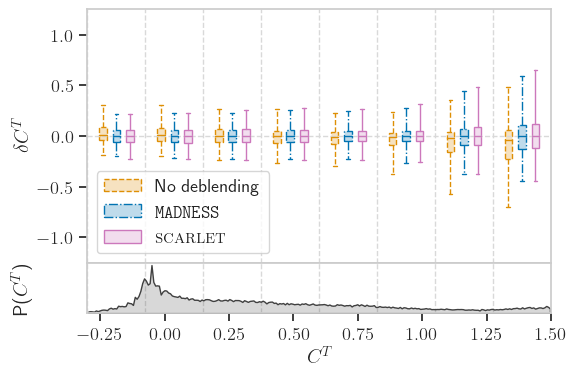

In [ ]:
(
    fig,
    median_shear,
    q1_shear,
    q3_shear,
    whislo_shear,
    whishi_shear,
) = madness_deblender.boxplot.boxplot_func(
    boxplot_color_df,
    x=color_bands + "_truth",
    y=color_bands + "_color_err_true",
    z="type",
    xlim=color_limits,
    ylim=(-1.25, 1.25),
    x_scale=None,
    legend=["No deblending", madness_plot_label, scarlet_plot_label],
    x_label="$C^T$",
    y_label=r"$\delta C^T$",
    y_label_hist=r"P($C^T$)",
    legend_remove=False,
    legend_location="lower left",
    whis=[5, 95],
    percents=[25, 75],
    palette=[blended_plot_color, madness_plot_color, scarlet_plot_color],  # 0.35,
    nbins=8,
    ls=[blended_plot_ls, madness_plot_ls, scarlet_plot_ls],
)
plt.savefig(
    os.path.join(
        "results",
        density_level + "_density",
        "temp",
        "bms_bias_true_color_box_plot.pdf",
    )
)
plt.savefig(
    os.path.join(
        "results",
        density_level + "_density",
        "temp",
        "bms_bias_true_color_box_plot.png",
    )
)

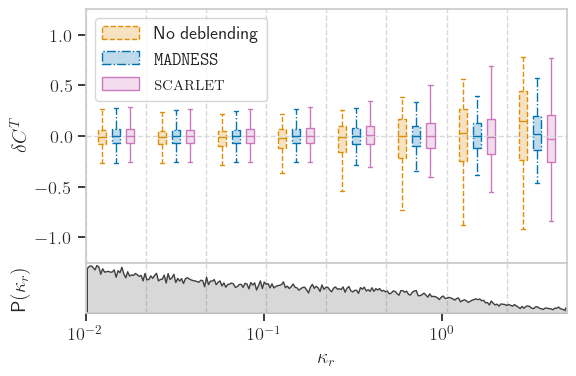

In [ ]:
(
    fig,
    median_shear,
    q1_shear,
    q3_shear,
    whislo_shear,
    whishi_shear,
) = madness_deblender.boxplot.boxplot_func(
    boxplot_color_df,
    x="r_contamination",
    y=f"{color_bands}_color_err_true",
    z="type",
    xlim=(1e-2, 5),
    ylim=(-1.25, 1.25),
    x_scale="log",
    legend=["No deblending", madness_plot_label, scarlet_plot_label],
    x_label=r"$\kappa_r$",
    y_label=r"$\delta C^T$",
    y_label_hist=r"P$(\kappa_r)$",
    legend_remove=False,
    whis=[5, 95],
    percents=[25, 75],
    palette=[blended_plot_color, madness_plot_color, scarlet_plot_color],  # 0.35,
    nbins=8,
    ls=[blended_plot_ls, madness_plot_ls, scarlet_plot_ls],
)
plt.savefig(
    os.path.join(
        "results",
        density_level + "_density",
        "temp",
        "bms_contamination_true_color_box_plot.pdf",
    )
)
plt.savefig(
    os.path.join(
        "results",
        density_level + "_density",
        "temp",
        "bms_contamination_true_color_box_plot.png",
    )
)

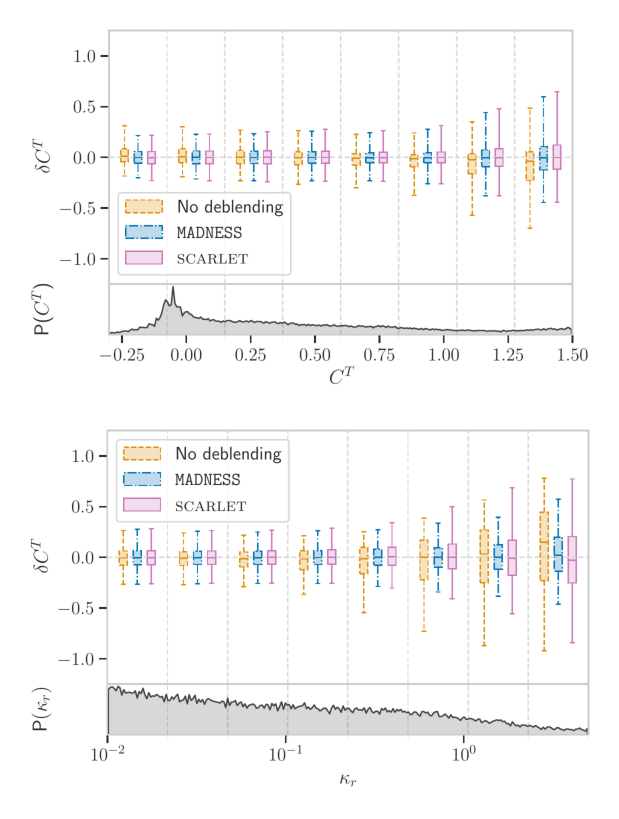

In [ ]:
f, axarr = plt.subplots(2, 1, figsize=(6, 8))

# axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))

axarr[0].imshow(
    convert_from_path(
        os.path.join(
            "results",
            density_level + "_density",
            "temp",
            "bms_bias_true_color_box_plot.pdf",
        )
    )[0]
)
axarr[1].imshow(
    convert_from_path(
        os.path.join(
            "results",
            density_level + "_density",
            "temp",
            "bms_contamination_true_color_box_plot.pdf",
        )
    )[0]
)


# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout(pad=0)

plt.savefig(
    os.path.join(
        "results", density_level + "_density", "color_true_boxplot_results.pdf"
    ),
    format="pdf",
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(
        "results", density_level + "_density", "temp", "color_true_boxplot_results.png"
    )
)

plt.show()

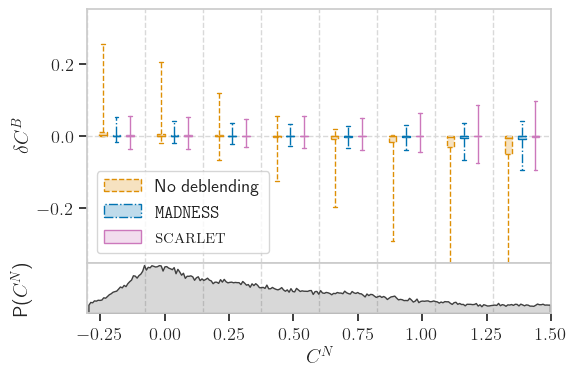

In [ ]:
(
    fig,
    median_shear,
    q1_shear,
    q3_shear,
    whislo_shear,
    whishi_shear,
) = madness_deblender.boxplot.boxplot_func(
    boxplot_color_df,
    x=color_bands + "_phot",
    y=color_bands + "_color_err_phot",
    z="type",
    xlim=color_limits,
    ylim=(-0.35, 0.35),
    x_scale=None,
    legend=["No deblending", madness_plot_label, scarlet_plot_label],
    x_label=r"$C^N$",
    y_label=r"$\delta C^B$",
    y_label_hist=r"P($C^N$)",
    legend_location="lower left",
    legend_remove=False,
    whis=[5, 95],
    percents=[25, 75],
    palette=[blended_plot_color, madness_plot_color, scarlet_plot_color],  # 0.35,
    nbins=8,
    ls=[blended_plot_ls, madness_plot_ls, scarlet_plot_ls],
    sns_font_scale=1.2,
)
plt.savefig(
    os.path.join(
        "results", density_level + "_density", "temp", "bms_bias_color_box_plot.pdf"
    )
)
plt.savefig(
    os.path.join(
        "results", density_level + "_density", "temp", "bms_bias_color_box_plot.png"
    ),
)

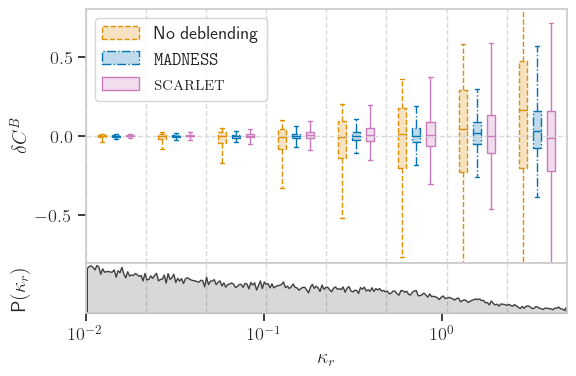

In [ ]:
(
    fig,
    median_shear,
    q1_shear,
    q3_shear,
    whislo_shear,
    whishi_shear,
) = madness_deblender.boxplot.boxplot_func(
    boxplot_color_df,
    x="r_contamination",
    y=f"{color_bands}_color_err_phot",
    z="type",
    xlim=(1e-2, 5),
    ylim=(-0.8, 0.8),
    x_scale="log",
    legend=["No deblending", madness_plot_label, scarlet_plot_label],
    x_label=r"$\kappa_r$",
    y_label=r"$\delta C^B$",
    y_label_hist=r"P$(\kappa_r)$",
    legend_remove=False,
    whis=[5, 95],
    percents=[25, 75],
    palette=[blended_plot_color, madness_plot_color, scarlet_plot_color],  # 0.35,
    nbins=8,
    ls=[blended_plot_ls, madness_plot_ls, scarlet_plot_ls],
    sns_font_scale=1.2,
)
plt.savefig(
    os.path.join(
        "results",
        density_level + "_density",
        "temp",
        "bms_contamination_color_box_plot.pdf",
    )
)
plt.savefig(
    os.path.join(
        "results",
        density_level + "_density",
        "temp",
        "bms_contamination_color_box_plot.png",
    ),
)

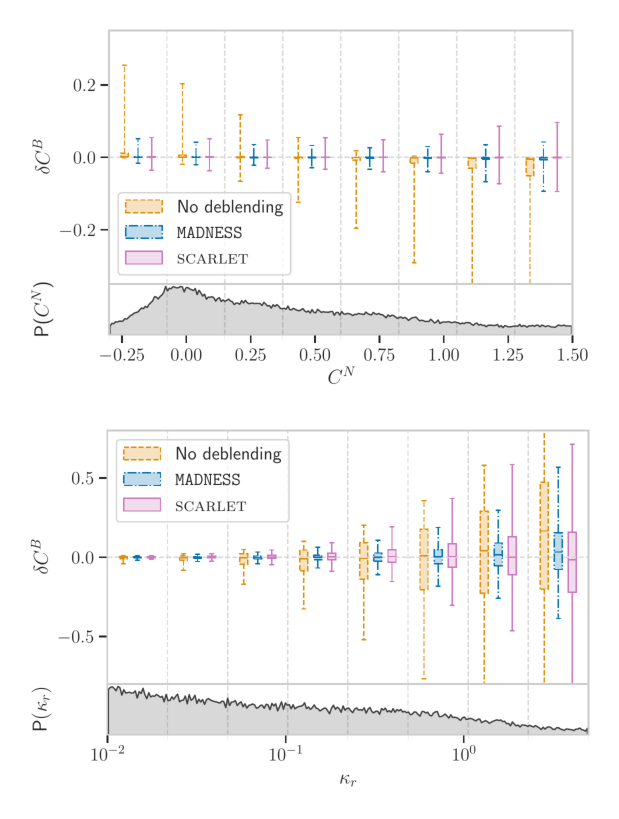

In [ ]:
f, axarr = plt.subplots(2, 1, figsize=(6, 8))

# axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))
axarr[0].imshow(
    convert_from_path(
        os.path.join(
            "results", density_level + "_density", "temp", "bms_bias_color_box_plot.pdf"
        )
    )[0]
)
axarr[1].imshow(
    convert_from_path(
        os.path.join(
            "results",
            density_level + "_density",
            "temp",
            "bms_contamination_color_box_plot.pdf",
        )
    )[0]
)


# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout(pad=0)

plt.savefig(
    os.path.join("results", density_level + "_density", "color_boxplot_results.pdf"),
    format="pdf",
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(
        "results", density_level + "_density", "temp", "color_boxplot_results.png"
    )
)

plt.show()